## Business Problem

### Business Situation

During the annual review with Sales team, the Sales Manager analyzed the results and saw many health insurances accounts registering loss instead profit along the year (i.e, medical costs billed x annual health insurance received). Several discussion have araisen but at the end Sales Manager gathered the Data team and Sales team and made the question: What's the right (best) price to offer health insurance to our customers according to each customer profile in order to cover usage and ensure profitability?

### Business Understading

A) Business problem (open question) - What's the best price to offer health insurance to each customer?

B) Business understanding  

- Motivation? Instead of using the actual method (sort of mean by age group plus family group) the Sales Manager wants to understand more deeply the relationship between personal charactheristics, habits, etc to be more precise on health insurance proposals

- Root cause: Annual Health insurance precification 

- Scope: (closed affirmation): 
  - Firstly: Provide optimal annual price to maximize profit based personal characteristics: sex, age, location, family size, weight and height - BMI, smoking habits. 
  - Secondarily, propose to engage customer to improve habits (health program) in order to reduce risk factors (BMI and smoking), propose reduced prices but higher margins.
    
- Who are the stakeholder? Sales Manager

#### Solution Planning

- Solution overview:
 - Kind of problem: Medical Costs Prediction
 - Potential methods: Regression

- Output: 
 - Comparative report with actual cost versus actual price then comparative report actual cost versus ML predicted proposal (all these summing up calculating profitability)

 - Dashboard on Streamlit where salesperson can input data from customer and ML algo predict health cost to make insurance proposal. On Streamlit, sugestion to change habits and reduce insurance costs, ML algo recalculate (and increase margins) 

- Steps:

  - 1)Collect data
  - 2) Understand data and its metadata
  - 3) Deal with missing, outliers, types casting, spelling
  - 4) Define hypothesis mindmap to obtain insights and explore data
  - 5) Calculate mean medical cost to each age group according to dataset (set baseline)
  - 6) Prepare data to ML (encodings, transformations, features engineering and selection)
  - 7) ML modeling (propose X linears and X non-linear algos)
  - 8) Evaluate results (and see necessity to HP fine tuning for 1st crisp cycle)
  - 9) Translate ML results to Business results and built the comparative report => evalute with business if we need to improve more ML performance
  - 10) Built Streamlit interface
  - 11) Deploy on Heroku

- Input:
 - Data Sources: Kaggle

 - Tools: 
   - Languages: Python 3.9
   - Main Libs: pandas, numpy, scipy, sklearn, xgboost, Flask(?)
   - IDEs: Jupyter Nb, Pycharm, Atom
   - Web: Streamlit/Heroku

#### Project Assumptions

- Actual health insurance proposals are made considering the mean of age group and aditional family group member
- New 
- Database cost scope?  2020?
- Actual Gross (normal) Margins = 10%
- Program Changing Habits will double margins = XX%
- Set assumptions accordingly to EDA how much (%) reduce costs if change habits

#### Others

C) Insights


D) Business Results


E) Conclusion (Objectives reached? Problems faced?)


F) Next Steps
- Mindmap Hypothesis brought many other agents/attributes that influences in medical costs (initially we have only 4). On next CRISP interaction, It's important to gather more data in order to reduce de prediction error. 

G) Lessons learned

### Data Fields

- age: age of primary beneficiary

- sex: insurance contractor gender, female, male

- bmi: Body mass index, providing an understanding of body, weights that are relatively high or low relative to height, objective index of body weight (kg / m ^ 2) using the ratio of height to weight, ideally 18.5 to 24.9

- children: Number of children covered by health insurance / Number of dependents

- smoker: Smoking

- region: the beneficiary's residential area in the US, northeast, southeast, southwest, northwest.

- charges: Individual medical costs billed by health insurance

## 0. Imports

In [1]:
import pandas as pd
import numpy as np
import pickle

import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

import xgboost as xgb

from scipy                     import stats,special
from IPython.display           import Image

from sklearn.pipeline          import Pipeline
from sklearn.model_selection   import train_test_split, KFold, cross_val_score, GridSearchCV
from sklearn.metrics           import mean_absolute_error,mean_absolute_percentage_error,mean_squared_error, r2_score
from sklearn.compose           import ColumnTransformer, TransformedTargetRegressor
from sklearn.preprocessing     import RobustScaler, MinMaxScaler, StandardScaler, LabelEncoder, OneHotEncoder, OrdinalEncoder, PowerTransformer
from sklearn.feature_selection import RFE
from sklearn.neighbors         import KNeighborsRegressor
from sklearn.linear_model      import LinearRegression
from sklearn.ensemble          import RandomForestRegressor


### 0.1 Helper Functions

In [2]:
def outlier_detection(data, column):
    
    q1 = np.percentile(data[column], 25)
    q3 = np.percentile(data[column], 75)
    
    iqr = q3 - q1

    lo_lim = q1 - 1.5*iqr
    up_lim = q3 + 1.5*iqr
    
    outliers = [x for x in data[column] if (x > up_lim) | (x<lo_lim)]
    
    return sorted(outliers)    


def cramer_v( x, y ):
    cm = pd.crosstab( x, y ).values
    n = cm.sum()
    r, k = cm.shape

    chi2 = stats.chi2_contingency( cm )[0]
    chi2corr = max( 0, chi2 - (k-1)*(r-1)/(n-1) )

    kcorr = k - (k-1)**2/(n-1)
    rcorr = r - (r-1)**2/(n-1)
    return np.sqrt( (chi2corr/n) / ( min( kcorr-1, rcorr-1 ) ) )

def mean_percentage_error(y, yhat):
    return np.mean(((y - yhat)/y))

def ml_error(model_name, y, yhat ):
    
    mae= mean_absolute_error(y, yhat)
    mape= mean_absolute_percentage_error(y, yhat)
    rmse= np.sqrt(mean_squared_error(y, yhat))
    mpe= mean_percentage_error(y, yhat)
    r2 = r2_score(y,yhat)
    return pd.DataFrame({'Model':model_name,
                         'MAE':mae,
                         'MAPE':mape, 
                         'RMSE':rmse,
                         'MPE':mpe,
                         'R2':r2},
                         index=[0])

def cross_validation(model_name, model, data, kfold, verbose=False):

    mae_list=[]
    mape_list=[]
    rmse_list =[]
    lmbda = 0.050928257197834614
    
    data.reset_index(drop=True)
    
    for k in reversed(range(1, kfold+1)):
        
        if verbose:
            print('\n'+ model_name +'K-fold number: {}'.format(k))
            
        # start and end date for validation
        i_start = data.index.max() - k*kfold
        i_end = data.index.max() - (k-1)*kfold

        #splitting dataset for k-fold
        fold_val = data[( data.index >= i_start) & ( data.index <= i_end)].copy()
        fold_train = data[~data.isin(fold_val)].copy()

        #preparing training and validation dataset
        X_train = fold_train.drop(['charges'],axis=1)
        y_train = fold_train['charges']

        X_val = fold_val.drop(['charges'],axis=1)
        y_val = fold_val['charges']

        #model
        m = model.fit(X_train,y_train)

        #predict
        yhat_m = m.predict(X_val)

        #performance
        m_result = ml_error(model_name,  special.inv_boxcox(y_val,lmbda), special.inv_boxcox(yhat_m,lmbda))
        print(m_result)

        #store performance of each k-fold iteration
        mae_list.append(m_result['MAE'])
        mape_list.append(m_result['MAPE'])
        rmse_list.append(m_result['RMSE'])

    return pd.DataFrame({'Model Name':model_name,
            'MAE CV': np.round(np.mean(mae_list),2).astype('str') + ' +/- ' + np.round(np.std(mae_list),2).astype('str'),
            'MAPE CV': np.round(np.mean(mape_list),2).astype('str') + ' +/- ' + np.round(np.std(mape_list),2).astype('str'),
            'RMSE CV': np.round(np.mean(rmse_list),2).astype('str') + ' +/- ' + np.round(np.std(rmse_list),2).astype('str')
            },index=[0])

### 0.2 Loading Data

In [3]:
df_raw = pd.read_csv('dataset/insurance.csv',low_memory=False)

## 1. Data Description

In [4]:
df = df_raw.copy()

### 1.1 Data Dimensions

In [5]:
print('The dataset has {} rows'.format(df.shape[0]))
print('The dataset has {} attributes'.format(df.shape[1]))

The dataset has 1338 rows
The dataset has 7 attributes


In [6]:
df.columns

Index(['age', 'sex', 'bmi', 'children', 'smoker', 'region', 'charges'], dtype='object')

### 1.2 Data Types

In [7]:
df.head()

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


In [8]:
df.dtypes

age           int64
sex          object
bmi         float64
children      int64
smoker       object
region       object
charges     float64
dtype: object

All attributes have correct types defined

### 1.3 Missing Values

In [9]:
df.isna().sum()/df.shape[0]

age         0.0
sex         0.0
bmi         0.0
children    0.0
smoker      0.0
region      0.0
charges     0.0
dtype: float64

There isn't missing values

### 1.4 Outliers

<AxesSubplot:label='D', xlabel='charges'>

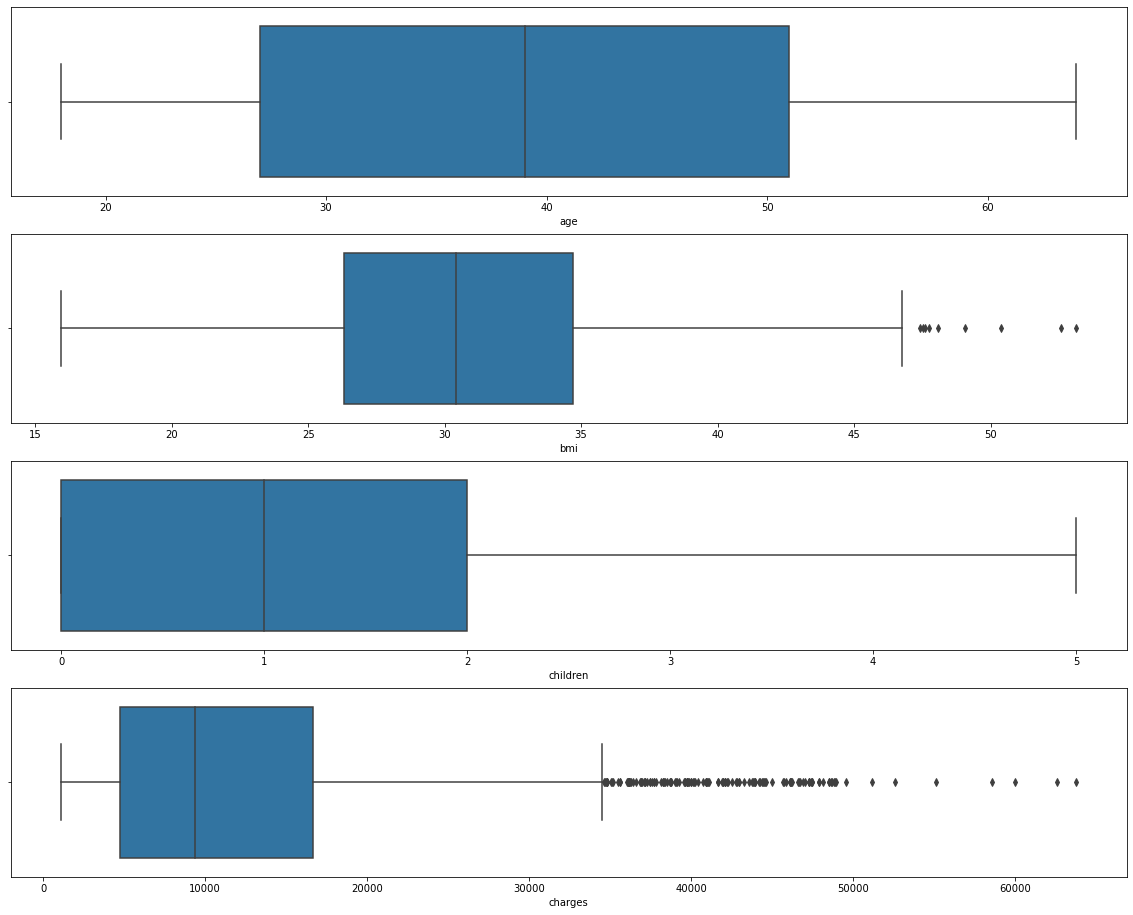

In [10]:
fig,ax = plt.subplot_mosaic('A;B;C;D',figsize=(20,16))
sns.boxplot(data=df,x='age',ax=ax['A'])
sns.boxplot(data=df,x='bmi',ax=ax['B'])
sns.boxplot(data=df,x='children',ax=ax['C'])
sns.boxplot(data=df,x='charges',ax=ax['D'])

In [11]:
#was detected outliers in 'bmi' as shown in boxplots above - obtaining data through iqr calculation
outliers_bmi = outlier_detection(df,'bmi')
outliers_bmi

[47.41, 47.52, 47.6, 47.74, 48.07, 49.06, 50.38, 52.58, 53.13]

In [12]:
df[df['bmi'].isin(outliers_bmi)]

,age,sex,bmi,children,smoker,region,charges
116,58,male,49.06,0,no,southeast,11381.32540
286,46,female,48.07,2,no,northeast,9432.92530
401,47,male,47.52,1,no,southeast,8083.91980
543,54,female,47.41,0,yes,southeast,63770.42801
847,23,male,50.38,1,no,southeast,2438.05520
860,37,female,47.60,2,yes,southwest,46113.51100
1047,22,male,52.58,1,yes,southeast,44501.39820
1088,52,male,47.74,1,no,southeast,9748.91060
1317,18,male,53.13,0,no,southeast,1163.46270


In [13]:
df = df[~df['bmi'].isin(outliers_bmi)]

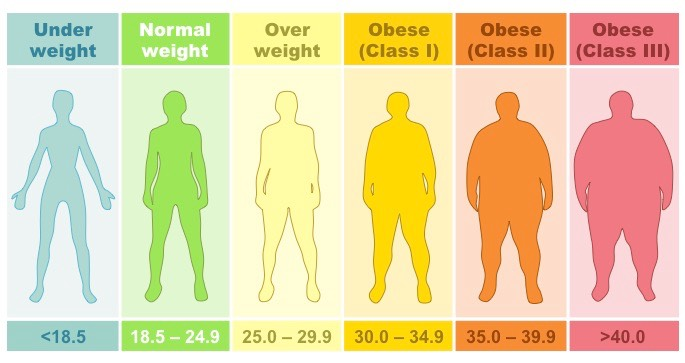

In [14]:
Image('C://Users//marco//OneDrive//Documents//repos//ds_em_producao//medical_cost_prediction//img/bmi-classification.jpeg')

Considering that there is 9 cases (0.6% of dataset) of extremely obesity, we will consider as normal record (no outliers)

### 1.5 Descriptive Statistics

#### 1.5.1 Numerical Attribs

In [15]:
num_attribs = df.select_dtypes(exclude='object')
num_attribs_metrics = num_attribs.agg(["count","mean","median","std","min","max","skew","kurtosis"]).T.reset_index().rename(columns= {'index' : 'features'})

In [16]:
num_attribs_metrics

,features,count,mean,median,std,min,max,skew,kurtosis
0,age,1329.0,39.203913,39.0000,14.047835,18.0000,64.00000,0.058413,-1.242973
1,bmi,1329.0,30.537348,30.3000,5.919946,15.9600,46.75000,0.157180,-0.365386
2,children,1329.0,1.096313,1.0000,1.207928,0.0000,5.00000,0.936628,0.191920
3,charges,1329.0,13212.333374,9361.3268,11997.236429,1121.8739,62592.87309,1.500577,1.527761


Numerical attributes metrics behave as expected (without discrepancy), will explore more in EDA

#### 1.5.2 Categorical Attribs

In [17]:
cat_attribs = df.select_dtypes(include='object')
cat_attribs_metrics = cat_attribs.agg(['count','unique']).T

In [18]:
cat_attribs_metrics

,count,unique
sex,1329,"[female, male]"
smoker,1329,"[yes, no]"
region,1329,"[southwest, southeast, northwest, northeast]"


Categorical attributes behave as expected (without mispelling, redundant categs, etc), will explore more in EDA

## 2. Feature Engineering

In [19]:
df2 = df.copy()

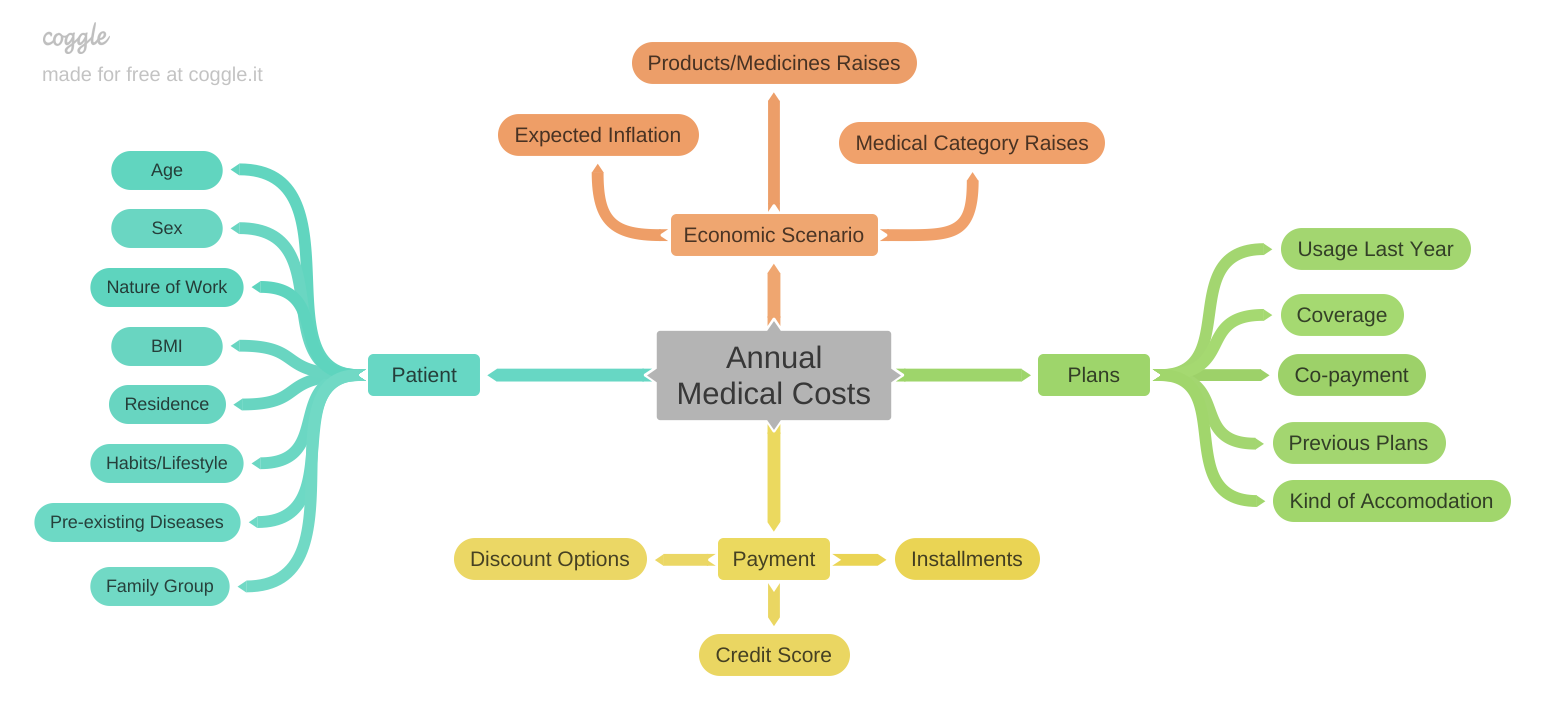

In [20]:
Image('C://Users//marco//OneDrive//Documents//repos//ds_em_producao//medical_cost_prediction//img/Annual_Medical_Costs_mindmap.png')

### 2.1 Hypothesis Brainstorming

#### 2.1.1 Hypothesis Patient

H1) Older (40+) customers are supposed to have double medical cost than younger

H2) Males customers are supposed to have higher medical cost than female

H3) Customers framed into obesity class are supposed to cost more than double than others

H4) Southern customers are supposed to cost more than Northern customers

H5) Customers with 0-2 child are supposed to cost 30% less than customer with 3+ children

H6) Smoker customers are supposed to have higher medical cost than non-smokers

Others - Data regarding pre-existing diseases and ocuppation will be collected in next crisp cycle

#### 2.1.2 Hypothesis Plans

Data will be gathered in next crisp cycle

#### 2.1.3 Hypothesis Economic Scenario

Data will be gathered in next crisp cycle

#### 2.1.4 Hypothesis Payments

Data will be gathered in next crisp cycle

#### 2.1.5 Hypothesis Prioritized

- Due to a lack of data in this crisp interaction (will be address in next steps), we will evaluate only hypothesis related to data that we have now and when prediction moment:

H1) Older (40+) customers are supposed to have double medical cost than younger

H2) Males customers are supposed to have higher medical cost than female

H3) Customers framed into obesity class are supposed to cost more than double than others

H4) Southern customers are supposed to cost more than Northern customers

H5) Customers with 0-2 child are supposed to cost 30% less than customer with 3+ children

H6) Smoker customers are supposed to have higher medical cost than non-smokers

### 2.3 Feature Engineering

In [21]:
# obesity (<18.5 underweight, 18,5 - 24.9 normal weight, 25-29.9 overweight, 30-34,9 obese I, 35-39.9 obese II, >40 obese III)
categ_weight = lambda x: 'underweight' if x < 18.5 else 'normal weight' if x < 25 else 'overweight' if x < 30 else 'obese I' if x < 35 else 'obese II' if x < 40 else 'obese III'

In [22]:
df2['bmi class'] = df2['bmi'].apply(categ_weight)

In [23]:
#For age class? obese smoker?

On next CRISP explore age class binning, obese smoker classification

## 3. Feature Filtering

### 3.1 Attributes Filtering

In [24]:
#derived bmi class from bmi and will not be necessary anymore
#df2 = df2.drop(columns='bmi')

### 3.2 Rows Filtering

No rows filtering

## 4. Exploratory Data Analysis

In [25]:
df3 = df2.copy()

### 4.1 Univariate Analysis

#### 4.1.1 Response Variable

Text(0.5, 1.0, 'Charges')

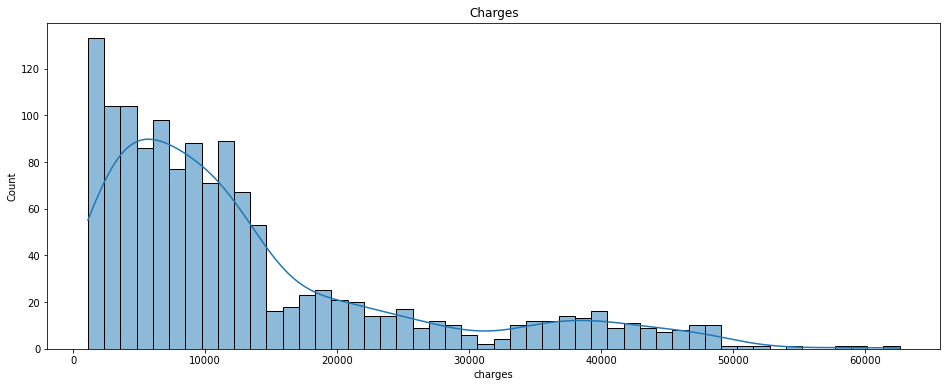

In [26]:
fig,ax = plt.subplot_mosaic('A',figsize=(16,6))
sns.histplot(data=df3['charges'], bins=50,kde=True,ax=ax['A'])
ax['A'].set_title('Charges')

Looks like an exponential distribution that need be transformed later (probably box-cox transformation fits)

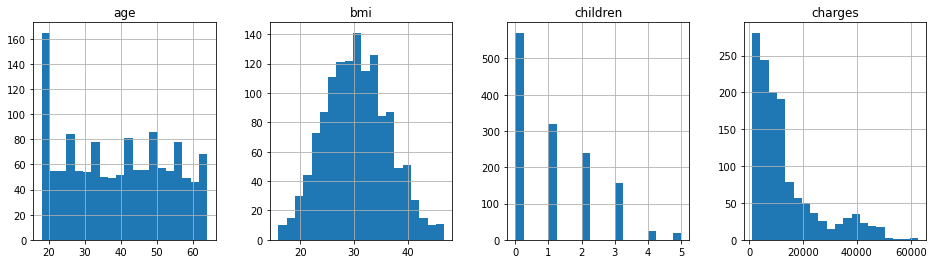

In [27]:
num_att = df3.select_dtypes(exclude='object')
num_att.hist(bins=20,layout=(1,4),figsize=(16,4));

### 4.2 Bivariate Analysis

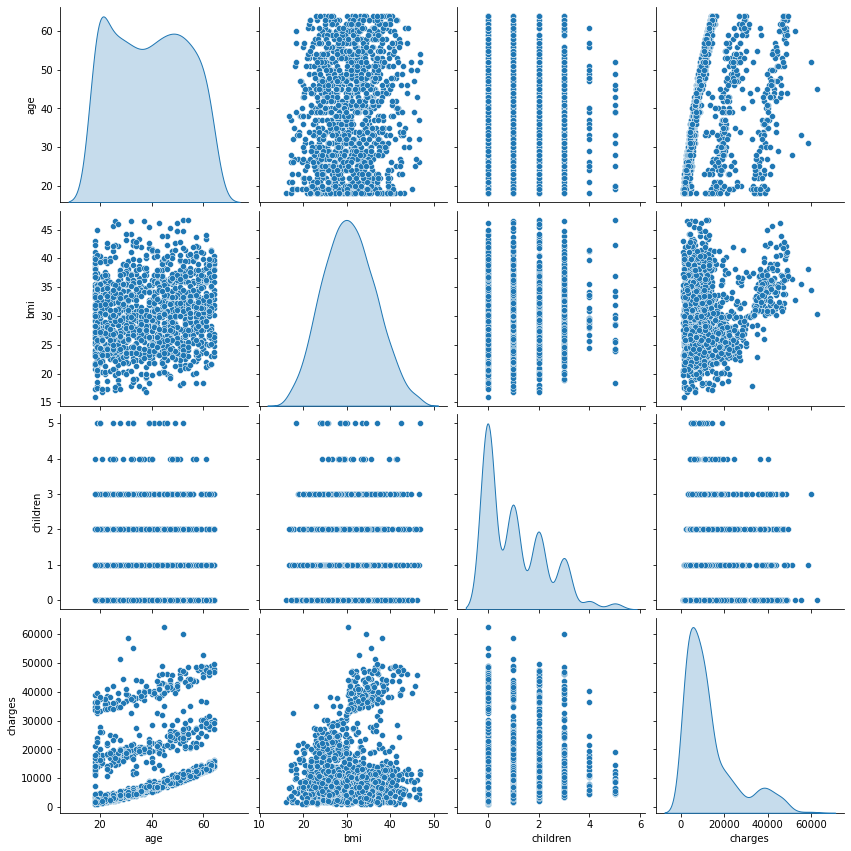

In [28]:
sns.pairplot(data=df3, height=3, diag_kind = 'kde');

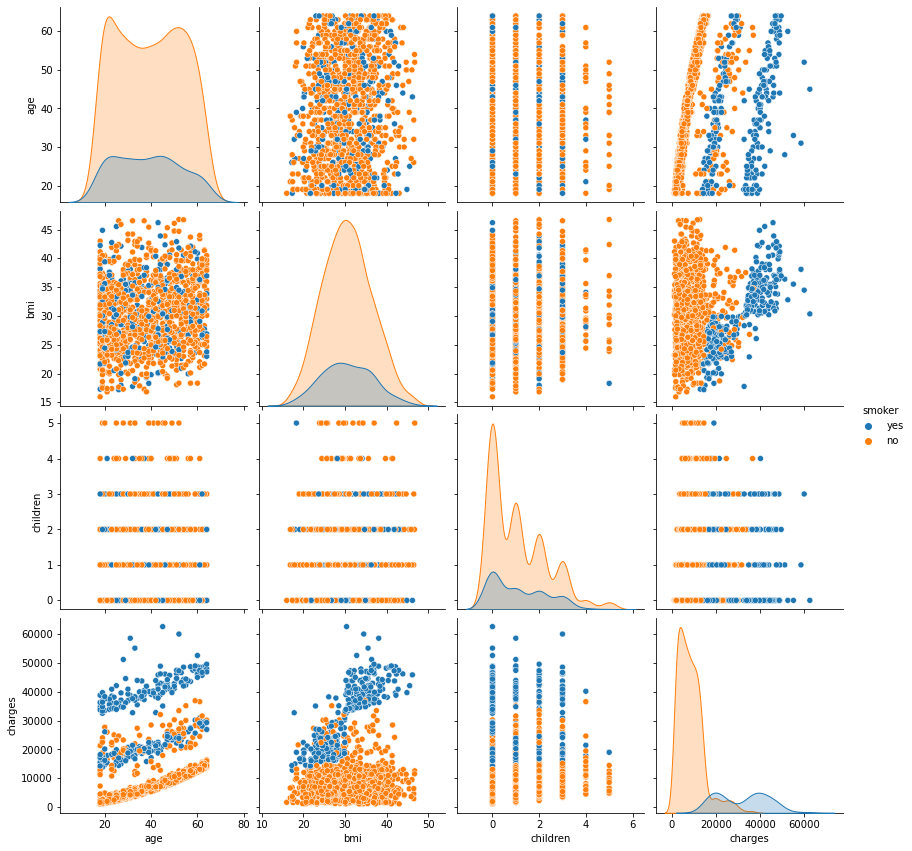

In [29]:
sns.pairplot(data=df3, height=3, hue='smoker');

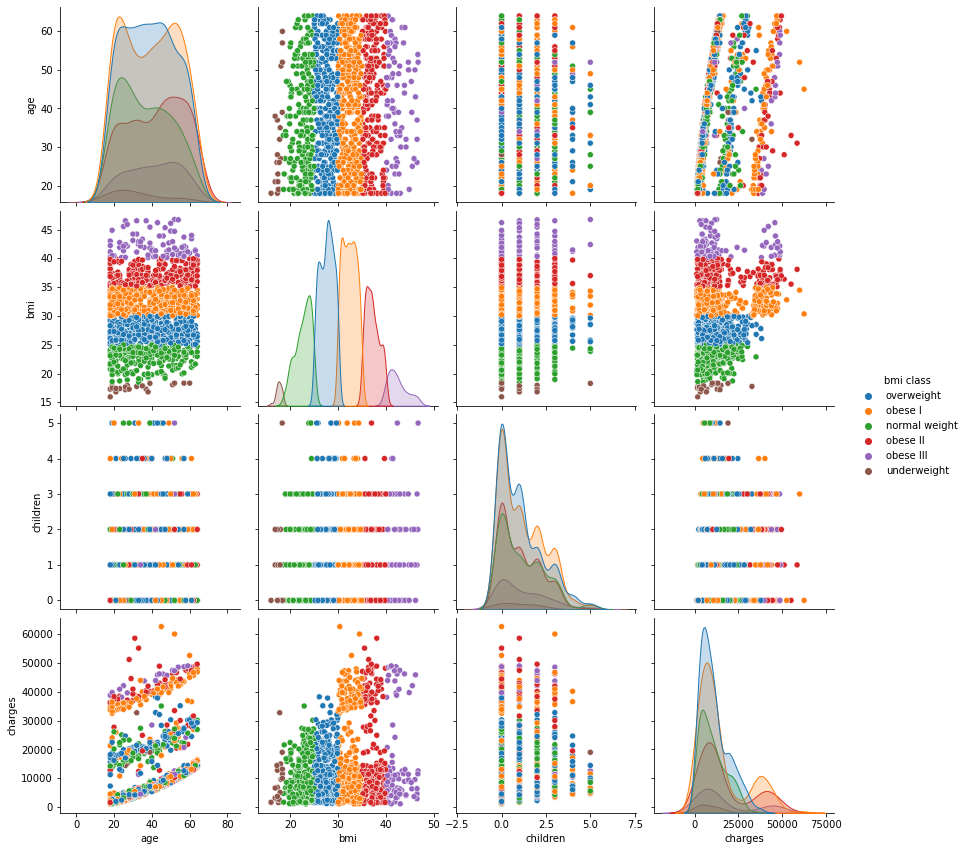

In [30]:
sns.pairplot(data=df3, height=3, hue='bmi class');

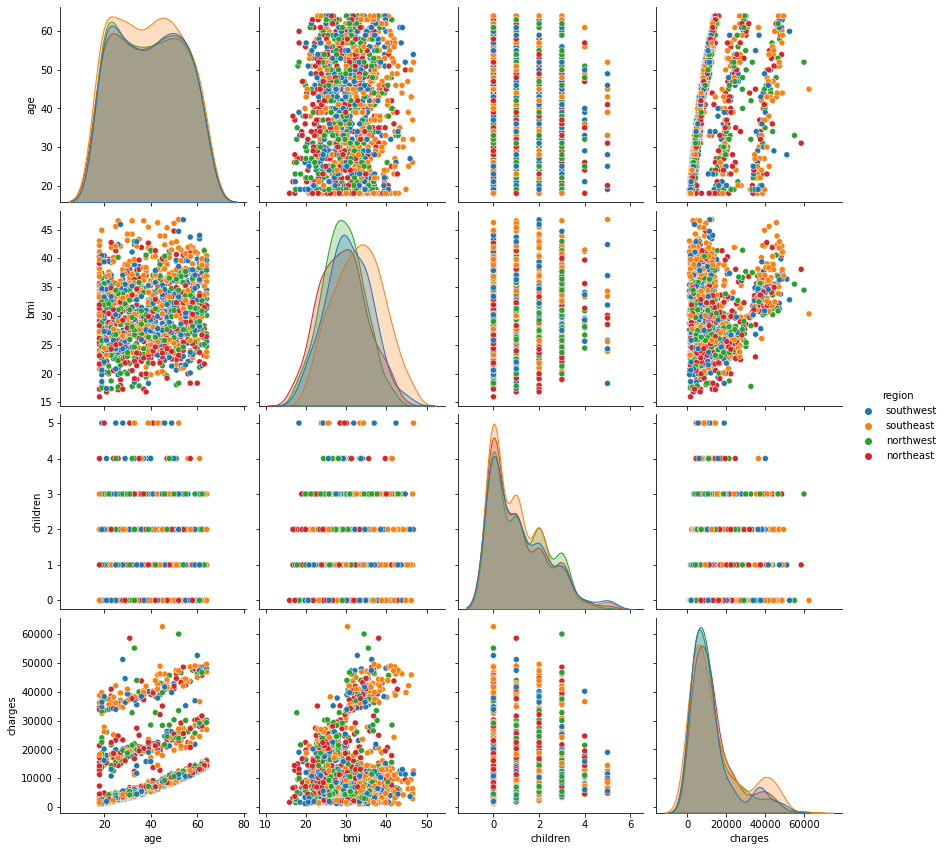

In [31]:
sns.pairplot(data=df3, height=3, hue='region');

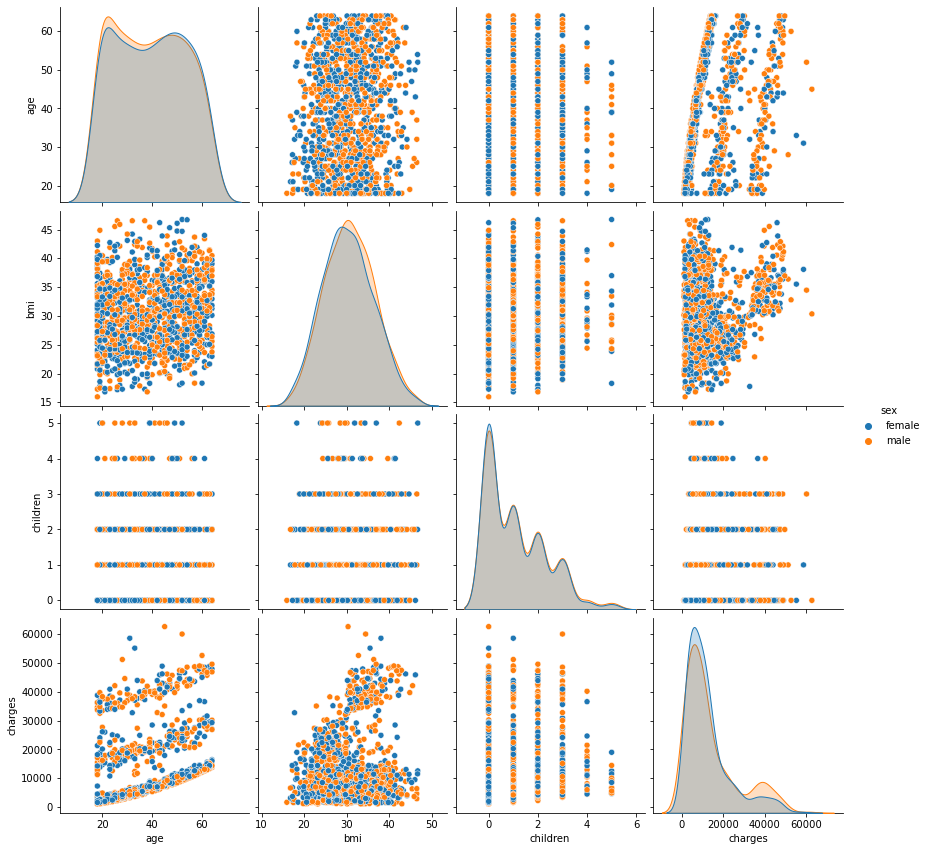

In [32]:
sns.pairplot(data=df3, height=3, hue='sex');

In [33]:
cat_att = df3.select_dtypes(include='object')
aux = pd.concat([cat_att,df3['charges']],axis=1)

In [34]:
pd.pivot_table(data=aux, index='smoker',columns='bmi class', values='charges')

bmi class,normal weight,obese I,obese II,obese III,overweight,underweight
smoker,,,,,,
no,7685.656014,8532.142079,9670.440600,8286.373542,8257.961955,5532.992453
yes,19942.223641,39640.592893,42753.622873,44468.787325,22495.874163,18809.824980


In [35]:
pd.pivot_table(data=aux, index='smoker',columns='sex', values='charges')

sex,female,male
smoker,,
no,8761.069043,8102.088227
yes,30249.563122,32969.478176


In [36]:
pd.pivot_table(data=aux, index='smoker',columns='region', values='charges')

region,northeast,northwest,southeast,southwest
smoker,,,,
no,9164.487165,8556.463715,8059.624547,8019.284513
yes,29673.536473,30192.003182,34411.493087,32026.178450


In [37]:
pd.pivot_table(data=aux, index='region',columns='bmi class', values='charges')

bmi class,normal weight,obese I,obese II,obese III,overweight,underweight
region,,,,,,
northeast,11317.394238,16035.378469,18081.018409,16372.580926,10810.640252,8914.423920
northwest,10000.515592,13337.560067,16914.210949,15679.579143,11432.133012,9223.351214
southeast,13123.557044,13914.008281,17301.217834,18360.235967,10862.673043,NaN
southwest,7246.518417,14574.002602,15941.684302,7901.832167,10786.970274,7778.771333


In [38]:
pd.pivot_table(data=aux, index='region',columns='sex', values='charges')

sex,female,male
region,,
northeast,12975.204888,13854.005374
northwest,12479.870397,12354.119575
southeast,13210.756836,15977.762699
southwest,11058.019340,13412.883576


#### 4.2.1 Hypothesis Exploration

H1) Older (40+) customers are supposed to have double medical cost than younger

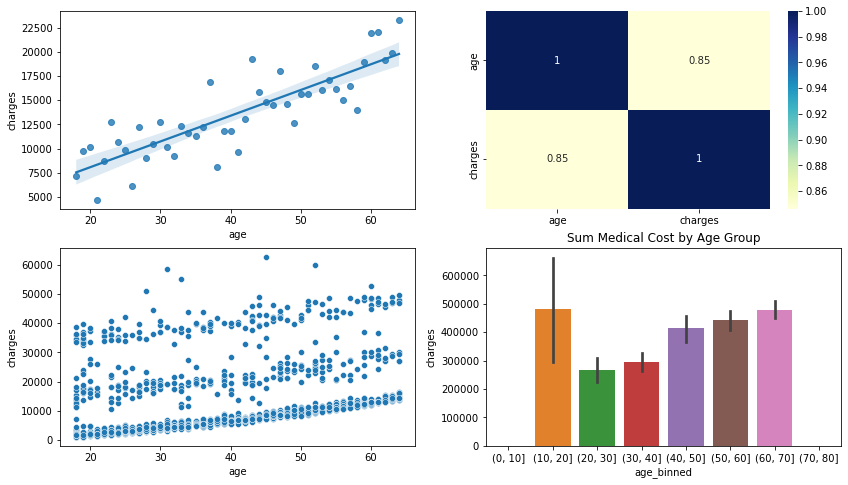

In [39]:
temp = df3[['age','charges']].groupby('age').mean().reset_index()
temp1 = df3[['age','charges']].groupby('age').sum().reset_index()


bins = list(np.arange(0, 81, 10))
temp1['age_binned'] = pd.cut(temp1['age'],bins=bins)

fig, ax = plt.subplot_mosaic('AB;CD',figsize=(14,8))
sns.regplot(data=temp, x='age', y='charges', ax=ax['A'])
sns.heatmap(temp.corr(),annot=True,cmap='YlGnBu',ax=ax['B'])
sns.scatterplot(data=df3, x='age',y='charges',ax=ax['C'])
sns.barplot(data=temp1, x='age_binned',y='charges',ax=ax['D'])
ax['D'].set_title('Sum Medical Cost by Age Group');

##### H2) Males customers are supposed to have higher medical cost than female

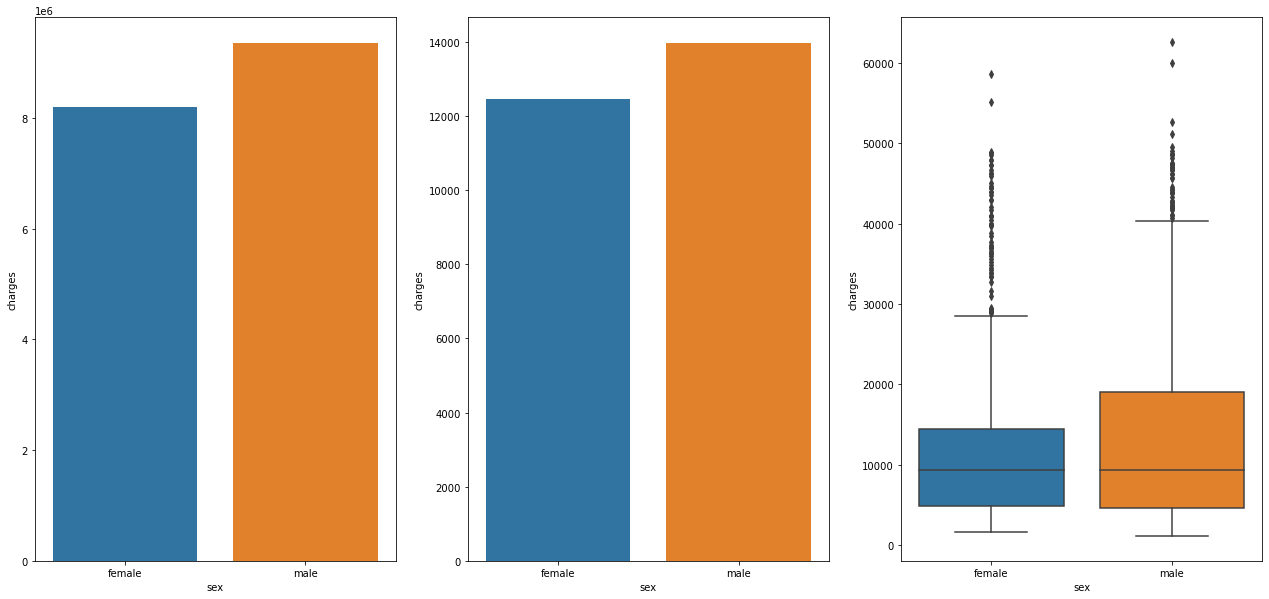

In [40]:
temp21 = df3[['sex','charges']].groupby('sex').sum().reset_index()
temp22 = df3[['sex','charges']].groupby('sex').mean().reset_index()


fig,ax=plt.subplot_mosaic('ABC',figsize=(22,10))
sns.barplot(data=temp21, x='sex',y='charges',ax=ax['A'])
sns.barplot(data=temp22, x='sex',y='charges',ax=ax['B'])
sns.boxplot(data=df3, x='sex',y='charges',ax=ax['C']);

##### H3) Customers framed into obesity class are supposed to cost more than double than others

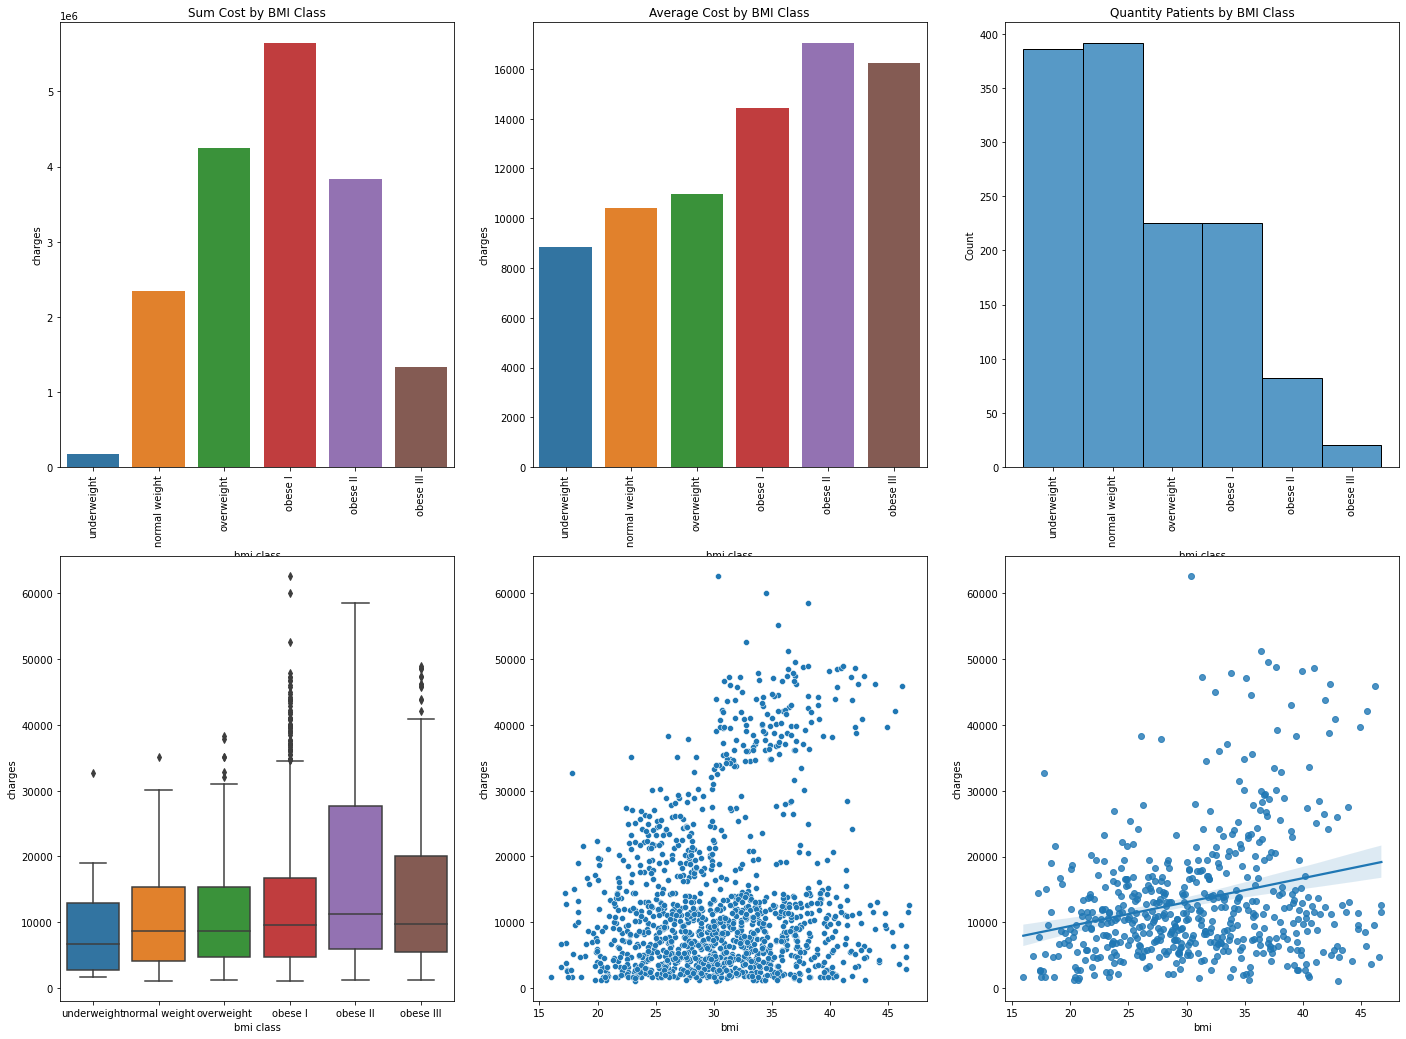

In [41]:
temp33 = df3[['bmi class', 'charges']].groupby('bmi class').sum().reset_index()
temp34 = df3[['bmi class', 'charges']].groupby('bmi class').mean().reset_index()
temp35 = df3[['bmi','charges']].groupby('bmi').mean().reset_index()

fig,ax = plt.subplot_mosaic('ABC;DEF',figsize=(24,18))
sns.histplot(data=df3['bmi class'], ax=ax['C'])
sns.barplot(data=temp33,x='bmi class', y='charges',order=['underweight','normal weight', 'overweight','obese I','obese II','obese III'],ax=ax['A'])
sns.barplot(data=temp34,x='bmi class', y='charges',order=['underweight','normal weight', 'overweight','obese I','obese II','obese III'],ax=ax['B'])
sns.boxplot(data=df3,x='bmi class', y='charges', order=['underweight','normal weight', 'overweight','obese I','obese II','obese III'], ax=ax['D'])
sns.scatterplot(data=df,x='bmi',y='charges', ax=ax['E'])
sns.regplot(data=temp35,x='bmi',y='charges', ax=ax['F'])

ax['A'].set_xticklabels(labels=['underweight','normal weight', 'overweight','obese I','obese II','obese III'],rotation=90)
ax['A'].set_title('Sum Cost by BMI Class')
ax['B'].set_xticklabels(labels=['underweight','normal weight', 'overweight','obese I','obese II','obese III'],rotation=90)
ax['B'].set_title('Average Cost by BMI Class')
ax['C'].set_xticklabels(labels=['underweight','normal weight', 'overweight','obese I','obese II','obese III'],rotation=90)
ax['C'].set_title('Quantity Patients by BMI Class');

#### H4) Southern customers are supposed to cost more than Northern customers

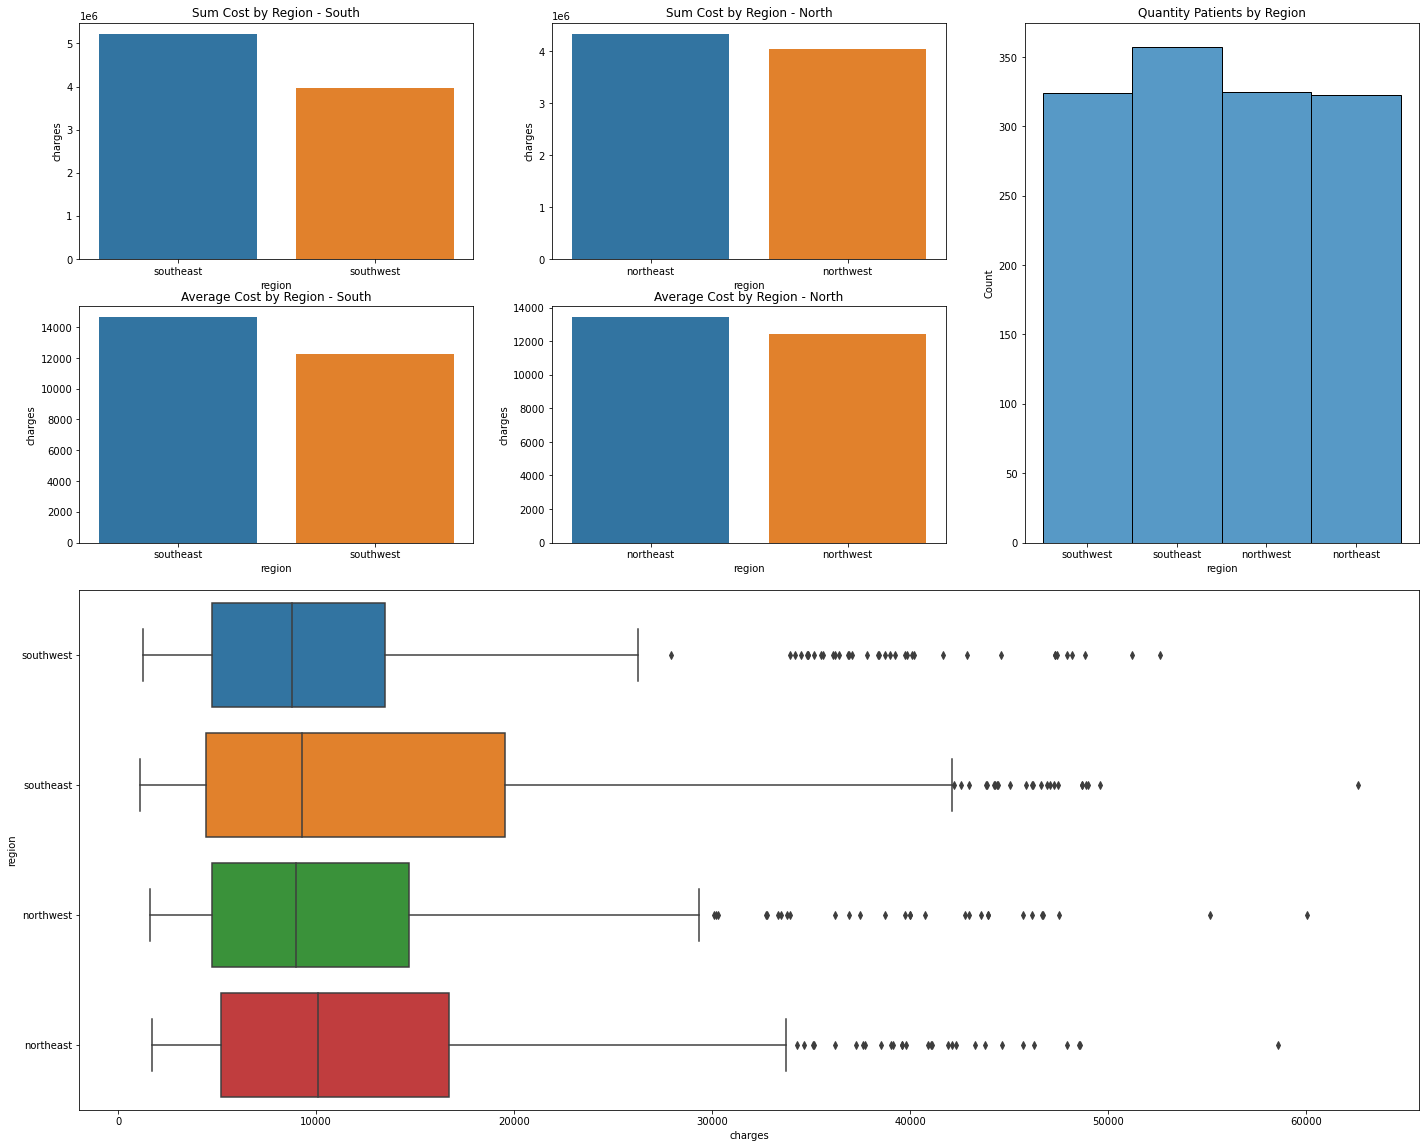

In [42]:
south = ['southeast','southwest']
north = ['northeast','northwest']

temp41 = df3[df3['region'].isin(south)].groupby('region').sum().reset_index()
temp42 = df3[df3['region'].isin(north)].groupby('region').sum().reset_index()

temp43 = df3[df3['region'].isin(south)].groupby('region').mean().reset_index()
temp44 = df3[df3['region'].isin(north)].groupby('region').mean().reset_index()


fig,ax = plt.subplot_mosaic('ABE;CDE;FFF;FFF',figsize=(24,20))

sns.barplot(data=temp41,x='region', y='charges',ax=ax['A'])
sns.barplot(data=temp42,x='region', y='charges',ax=ax['B'])

sns.barplot(data=temp43,x='region', y='charges',ax=ax['C'])
sns.barplot(data=temp44,x='region', y='charges',ax=ax['D'])

sns.histplot(data=df3['region'], ax=ax['E'])
sns.boxplot(data=df3, y='region', x='charges',orient='h', ax=ax['F'])


ax['A'].set_title('Sum Cost by Region - South')
ax['B'].set_title('Sum Cost by Region - North')
ax['C'].set_title('Average Cost by Region - South')
ax['D'].set_title('Average Cost by Region - North')
ax['E'].set_title('Quantity Patients by Region');

#### H5) Customers with 0-2 child are supposed to cost 30% less than customer with 3+ children

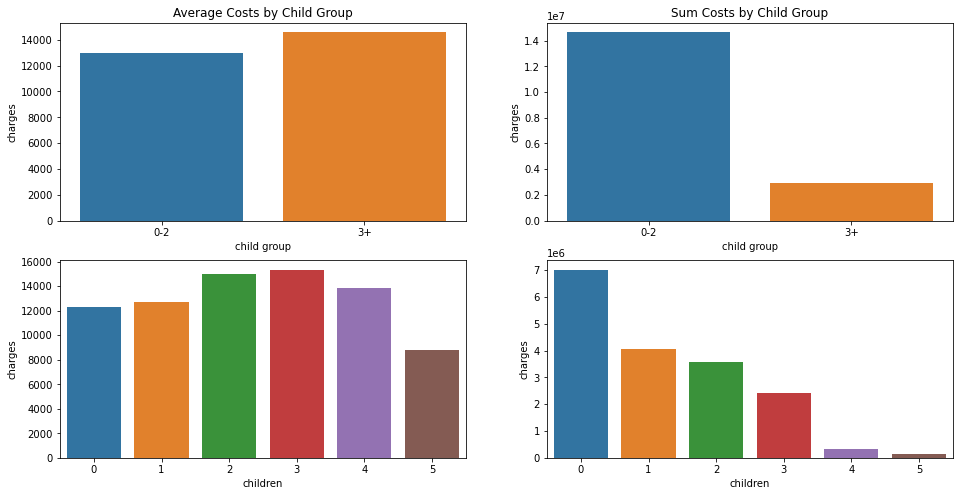

In [43]:
df3['child group'] = df3['children'].apply(lambda x: '0-2' if x<=2 else '3+')
temp51 = df3[['child group','charges']].groupby('child group').mean().reset_index()
temp52 = df3[['child group','charges']].groupby('child group').sum().reset_index()
temp53 = df3[['children','charges']].groupby('children').mean().reset_index()
temp54 = df3[['children','charges']].groupby('children').sum().reset_index()

fig, ax = plt.subplot_mosaic('AB;CD',figsize=(16,8))

sns.barplot(data=temp51, x='child group',y='charges',ax=ax['A'])
sns.barplot(data=temp52, x='child group',y='charges',ax=ax['B'])
sns.barplot(data=temp53, x='children',y='charges',ax=ax['C'])
sns.barplot(data=temp54, x='children',y='charges',ax=ax['D'])
ax['A'].set_title('Average Costs by Child Group');
ax['B'].set_title('Sum Costs by Child Group');
df3.drop(columns='child group',inplace=True)

#### H6) Smoker customers are supposed to have higher medical cost than non-smokers

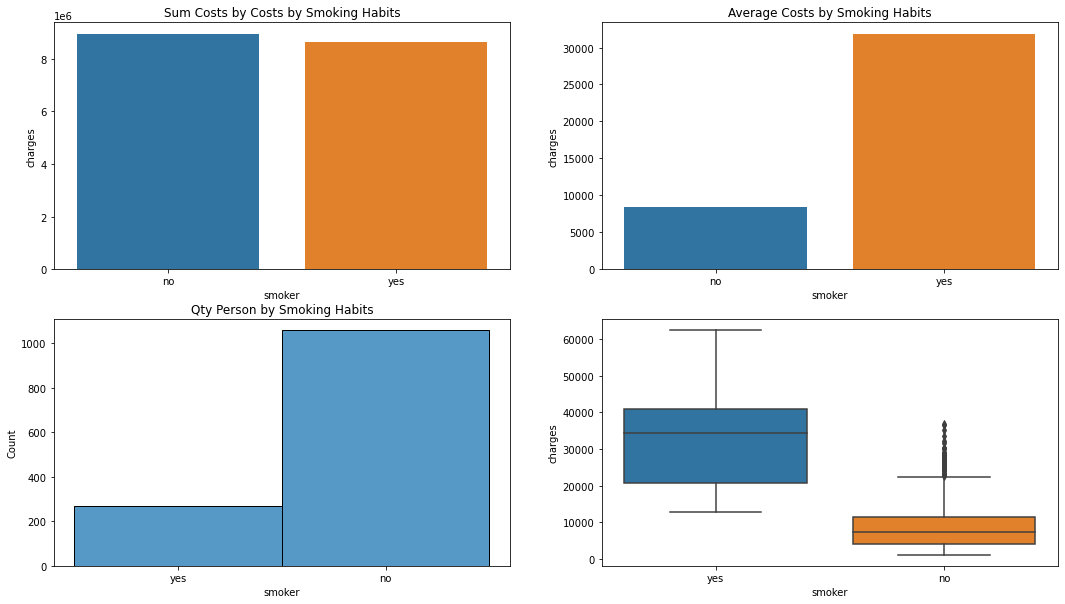

In [44]:
temp61 = df3[['smoker','charges']].groupby('smoker').sum().reset_index()
temp62 = df3[['smoker','charges']].groupby('smoker').mean().reset_index()


fig,ax=plt.subplot_mosaic('AB;CD',figsize=(18,10))
sns.barplot(data=temp61, x='smoker',y='charges',ax=ax['A'])
sns.barplot(data=temp62, x='smoker',y='charges',ax=ax['B'])
sns.histplot(data=df3['smoker'], ax=ax['C'])
sns.boxplot(data=df3, x='smoker',y='charges',ax=ax['D']);

ax['A'].set_title('Sum Costs by Costs by Smoking Habits');
ax['B'].set_title('Average Costs by Smoking Habits');
ax['C'].set_title('Qty Person by Smoking Habits');

### 4.1 Multivariate Analysis

#### Numerical Correlations

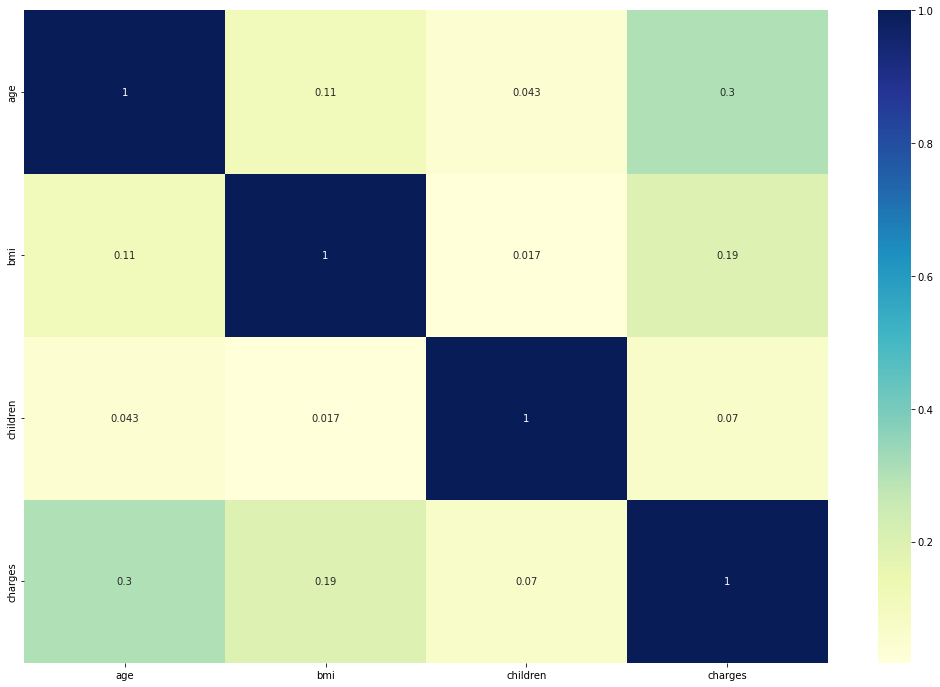

In [45]:
num_attrib = df3.select_dtypes(exclude='object')
num_attrib

plt.subplots(figsize=(18,12))
sns.heatmap(num_attrib.corr(method='pearson'),annot=True,cmap='YlGnBu');

#### Categorical Correlations

In [46]:
cat_attrib = df3.select_dtypes(include=['object'])

In [47]:
a0 = cramer_v(cat_attrib['sex'],cat_attrib['sex']) 
a1 = cramer_v(cat_attrib['sex'],cat_attrib['bmi class'])
a2 = cramer_v(cat_attrib['sex'],cat_attrib['smoker'])
a3 = cramer_v(cat_attrib['sex'],cat_attrib['region'])

a4 = cramer_v(cat_attrib['bmi class'],cat_attrib['sex'])
a5 = cramer_v(cat_attrib['bmi class'],cat_attrib['bmi class'])
a6 = cramer_v(cat_attrib['bmi class'],cat_attrib['smoker'])
a7 = cramer_v(cat_attrib['bmi class'],cat_attrib['region'])

a8 = cramer_v(cat_attrib['smoker'],cat_attrib['bmi class'])
a9 = cramer_v(cat_attrib['smoker'],cat_attrib['region'])
a10 = cramer_v(cat_attrib['smoker'],cat_attrib['smoker'])
a11 = cramer_v(cat_attrib['smoker'],cat_attrib['sex'])

a12 = cramer_v(cat_attrib['region'],cat_attrib['bmi class'])
a13 = cramer_v(cat_attrib['region'],cat_attrib['smoker'])
a14 = cramer_v(cat_attrib['region'],cat_attrib['sex'])
a15 = cramer_v(cat_attrib['region'],cat_attrib['region'])
 

cramer_v_table = pd.DataFrame({'sex':[a0,a1,a2,a3],
                              'bmi class': [a4,a5,a6,a7],
                              'smoker':[a8,a9,a10,a11],
                              'region': [a12,a13,a14,a15]} )

cramer_v_table = cramer_v_table.set_index(cramer_v_table.columns)

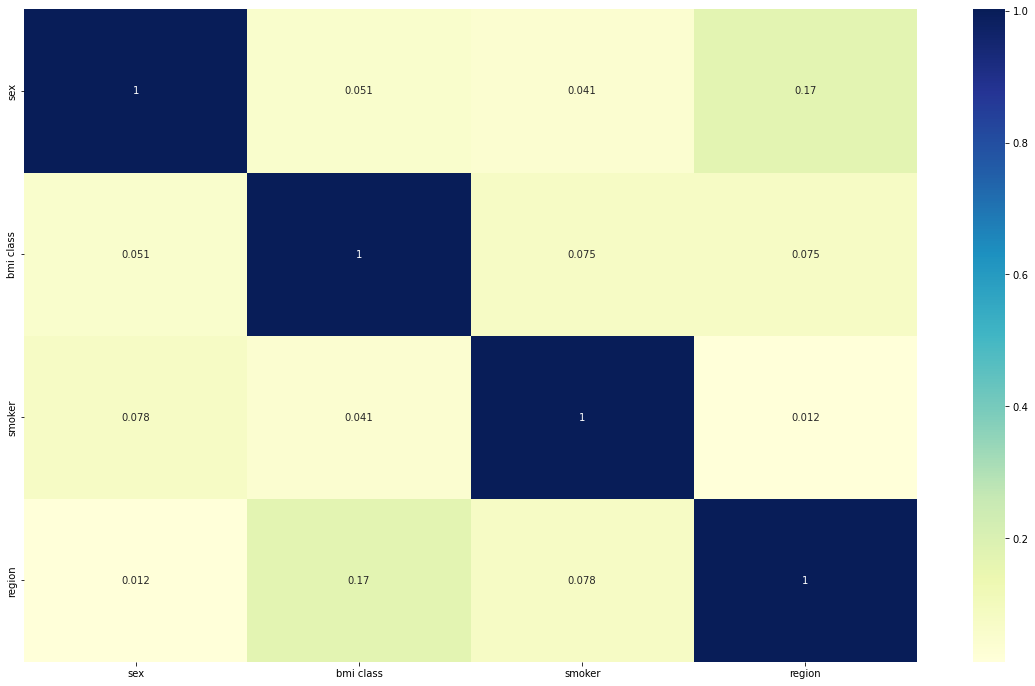

In [48]:
plt.subplots(figsize=(20,12))
sns.heatmap(cramer_v_table,annot=True,cmap='YlGnBu');

##### Conclusions

<h3>- On average, age have strong correlation with medical costs</h3>
<h3>- Family group doesnt affect too much medical charges</h3>
<h3>- Seems location doesnt affect significantly charges neither other variables</h3>
<h3>- Seems sex doesnt affect significantly charges neither other variables</h3>
<h3>- Seem BMI (and class) shows a good relationship with medical costs</h3>
<h3>- Smoking habits have huge impact on charges</h3>

## 5. Data Preparation

In [49]:
df3.head()

,age,sex,bmi,children,smoker,region,charges,bmi class
0,19,female,27.900,0,yes,southwest,16884.92400,overweight
1,18,male,33.770,1,no,southeast,1725.55230,obese I
2,28,male,33.000,3,no,southeast,4449.46200,obese I
3,33,male,22.705,0,no,northwest,21984.47061,normal weight
4,32,male,28.880,0,no,northwest,3866.85520,overweight


### 5.0 Split Train/Test

In [50]:
X = df3.drop(columns='charges')
y = df3['charges'].copy()
print('O tamanho de X é {} e de y é {}'.format(X.shape, y.shape))

#split 
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.25,random_state=7)
print('O tamanho de X_train é {} e de X_test é {}'.format(X_train.shape, X_test.shape))
print('O tamanho de y_train é {} e de y_test é {}'.format(y_train.shape, y_test.shape))

O tamanho de X é (1329, 7) e de y é (1329,)
O tamanho de X_train é (996, 7) e de X_test é (333, 7)
O tamanho de y_train é (996,) e de y_test é (333,)


### 5.1 Rescaling

In [51]:
rs = RobustScaler()

#bmi
X_train['bmi'] = rs.fit_transform(X_train[['bmi']].values)
X_test['bmi'] = rs.transform(X_test[['bmi']].values)
#pickle.dump(rs, open('C:\\Users\\marco\\OneDrive\\Documents\\repos\\ds_em_producao\\medical_cost_prediction\\parameters\\bmi_scaler.pkl','wb'))

In [52]:
#MinMaxScaler - Children , Age => bounded distribution

mms = MinMaxScaler()

X_train['children'] = mms.fit_transform(X_train[['children']].values)
X_test['children'] = mms.transform(X_test[['children']].values)
#pickle.dump(mms, open('C:\\Users\\marco\\OneDrive\\Documents\\repos\\ds_em_producao\\medical_cost_prediction\\parameters\\children_scaler.pkl','wb'))

In [53]:
X_train['age'] = mms.fit_transform(X_train[['age']].values)
X_test['age'] = mms.transform(X_test[['age']].values)
#pickle.dump(mms, open('C:\\Users\\marco\\OneDrive\\Documents\\repos\\ds_em_producao\\medical_cost_prediction\\parameters\\age_scaler.pkl','wb'))

### 5.2 Transformation

#### 5.2.1 Encoding

In [54]:
#Binary Encoding - sex
sex_mapping = {'male':0,'female':1}
X_train['sex'] = X_train['sex'].map(sex_mapping)
X_test['sex'] = X_test['sex'].map(sex_mapping)

#Binary Encoding - smoker
smoker_mapping = {'no':0,'yes':1}
X_train['smoker'] = X_train['smoker'].map(smoker_mapping)
X_test['smoker'] = X_test['smoker'].map(smoker_mapping)

#Dummies - region
X_train = pd.get_dummies(X_train,prefix=['region'],columns=['region'])
X_test = pd.get_dummies(X_test,prefix=['region'],columns=['region'])

#ordinal encoding - BMI class (evaluate to use target encoding next crisp)
bmi_order_mapping = {'underweight':0,'normal weight':1,'overweight':2, 'obese I':3, 'obese II':4,'obese III':5}
X_train['bmi class'] = X_train['bmi class'].map(bmi_order_mapping)
X_test['bmi class'] = X_test['bmi class'].map(bmi_order_mapping)

#### 5.2.2 Response Variable Transformation

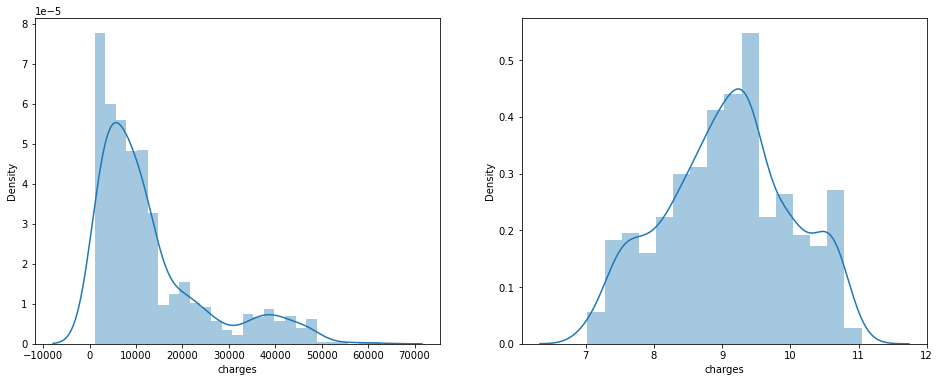

In [55]:
fig, ax = plt.subplots(1, 2, figsize=(16,6))

#plot original data
sns.distplot(y_train, ax = ax[0])

y_train = np.log1p(y_train)
y_test = np.log1p(y_test)

#plotting fitted data
sns.distplot(y_train, ax = ax[1]);

## 6. Feature Selection

In [56]:
#run Recursive Feature Selection to validate our conclusions from EDA
rfe = RFE(RandomForestRegressor(n_jobs=-1), n_features_to_select=3,step=5)
selector = rfe.fit(X_train, y_train)

In [57]:
print("Considering picking 3 features to model, RFE define following ranking:\n {}".format(list(zip(X_train.columns,rfe.ranking_))))

Considering picking 3 features to model, RFE define following ranking:
 [('age', 1), ('sex', 2), ('bmi', 1), ('children', 2), ('smoker', 1), ('bmi class', 3), ('region_northeast', 3), ('region_northwest', 3), ('region_southeast', 3), ('region_southwest', 3)]


In [58]:
columns_selected = X_train.loc[:,rfe.support_].columns
columns_selected

Index(['age', 'bmi', 'smoker'], dtype='object')

In [59]:
X_train

,age,sex,bmi,children,smoker,bmi class,region_northeast,region_northwest,region_southeast,region_southwest
232,0.021739,1,-1.479176,0.0,0,0,0,0,0,1
148,0.760870,1,0.848377,0.2,0,4,0,1,0,0
168,0.021739,1,0.183785,0.2,0,3,0,1,0,0
983,0.195652,1,0.037350,0.2,0,3,1,0,0,0
70,0.195652,1,-0.655106,0.0,1,1,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...
212,0.130435,0,-0.210464,0.4,0,2,0,1,0,0
505,0.413043,0,0.071143,0.6,0,3,0,1,0,0
540,0.347826,1,0.915963,0.6,0,4,0,0,0,1
1228,0.826087,0,0.492663,0.0,0,3,0,0,1,0


In [60]:
#X_train = X_train[columns_selected]
#X_test = X_test[columns_selected]

<h3>For this 1st CRISP interaction we will consider all features. For the 2nd only age, bmi and smoker as features (ranked as 1) to train the model</h3>

## 7. Machine Learning Modeling

### Single Performance

#### 7.1 Average Model - Actual

In [61]:
#model
aux = df3.copy()
bins = np.arange(aux['age'].min(),aux['age'].max()+5,10)
aux['age_binned'] = pd.cut(aux['age'],bins=bins,include_lowest=True)
price_table = aux[['age_binned','charges']].groupby('age_binned').mean().reset_index()

In [62]:
X_avg = aux.drop(columns='charges')
y_avg = aux['charges']
X_train_avg, X_test_avg, y_train_avg, y_test_avg = train_test_split(X_avg,y_avg,test_size=0.25,random_state=7)

In [63]:
#prediction (using price table)
yhat_avg = X_test_avg.reset_index().merge(price_table,how='left').set_index('index')['charges']

In [64]:
avg_result = ml_error('Avg Model',y_test_avg,yhat_avg)
avg_result

,Model,MAE,MAPE,RMSE,MPE,R2
0,Avg Model,9085.799931,1.102296,11677.507466,-0.808694,0.080778


In [65]:
temp = pd.concat([y_test_avg,yhat_avg],axis=1)
temp.columns.values[0] = 'charges'
temp.columns.values[1] = 'predictions'

In [66]:
temp['MAE'] = temp.apply(lambda x: mean_absolute_error([x['charges']],[x['predictions']]),axis=1)
temp['MAPE'] = temp.apply(lambda x: mean_absolute_percentage_error([x['charges']],[x['predictions']]),axis=1)

temp.head(10)

,charges,predictions,MAE,MAPE
51,3579.82870,9042.325399,5462.496699,1.525910
195,1639.56310,9042.325399,7402.762299,4.515082
752,14210.53595,20824.972901,6614.436951,0.465460
171,8116.68000,15750.549171,7633.869171,0.940516
217,2483.73600,9042.325399,6558.589399,2.640615
883,46255.11250,15750.549171,30504.563329,0.659485
942,2217.46915,9042.325399,6824.856249,3.077768
513,1256.29900,9042.325399,7786.026399,6.197590
276,2803.69785,9042.325399,6238.627549,2.225143
568,11552.90400,15750.549171,4197.645171,0.363341


#### 7.2 Linear Regression

In [67]:
#model
lr = LinearRegression().fit(X_train,y_train)

#prediction
yhat_lr = lr.predict(X_test)

#performance
result_lr = ml_error('Linear Regression',np.expm1(y_test), np.expm1(yhat_lr))

result_lr

,Model,MAE,MAPE,RMSE,MPE,R2
0,Linear Regression,4675.1552,0.263736,9113.876367,-0.050714,0.44008


#### 7.3 KNN

In [68]:
#model
knn = KNeighborsRegressor(n_neighbors=3).fit(X_train,y_train)

#prediction
yhat_knn = knn.predict(X_test)

#performance
result_knn = ml_error('K Neighbors Regressor',np.expm1(y_test), np.expm1(yhat_knn))
result_knn

,Model,MAE,MAPE,RMSE,MPE,R2
0,K Neighbors Regressor,3352.134416,0.264837,6198.621459,-0.019201,0.740994


#### 7.4 Random Forest

In [69]:
#model
rf = RandomForestRegressor(n_jobs=-1, random_state=42).fit(X_train,y_train)

#predict 
yhat_rf = rf.predict(X_test)

#performance
result_rf = ml_error('Random Forest Regressor', np.expm1(y_test), np.expm1(yhat_rf))

result_rf

,Model,MAE,MAPE,RMSE,MPE,R2
0,Random Forest Regressor,2205.38111,0.170647,4903.211935,-0.040767,0.837938


#### 7.5 XGBoost 

In [70]:
#model
xgb_model = xgb.XGBRegressor().fit(X_train,y_train)

#prediction
yhat_xgb = xgb_model.predict(X_test)

#performance
result_xgb = ml_error('XGBoost Regressor',np.expm1(y_test), np.expm1(yhat_xgb))

result_xgb

,Model,MAE,MAPE,RMSE,MPE,R2
0,XGBoost Regressor,2748.291669,0.190672,5673.338694,-0.018079,0.783031


#### 7.7 Comparing Single Performance

In [71]:
final_result = pd.concat([avg_result,result_lr,result_knn,result_rf,result_xgb]).reset_index(drop=True)
final_result

,Model,MAE,MAPE,RMSE,MPE,R2
0,Avg Model,9085.799931,1.102296,11677.507466,-0.808694,0.080778
1,Linear Regression,4675.155200,0.263736,9113.876367,-0.050714,0.440080
2,K Neighbors Regressor,3352.134416,0.264837,6198.621459,-0.019201,0.740994
3,Random Forest Regressor,2205.381110,0.170647,4903.211935,-0.040767,0.837938
4,XGBoost Regressor,2748.291669,0.190672,5673.338694,-0.018079,0.783031


### Cross Validation Performance

In [72]:
X = df3.drop(columns='charges')
y = df3['charges'].copy()
print('O tamanho de X é {} e de y é {}'.format(X.shape, y.shape))

#split 
X_train_cv, X_test_cv, y_train_cv, y_test_cv = train_test_split(X,y,test_size=0.25,random_state=42)
print('O tamanho de X_train é {} e de X_test é {}'.format(X_train_cv.shape, X_test.shape))
print('O tamanho de y_train é {} e de y_test é {}'.format(y_train_cv.shape, y_test.shape))



O tamanho de X é (1329, 7) e de y é (1329,)
O tamanho de X_train é (996, 7) e de X_test é (333, 10)
O tamanho de y_train é (996,) e de y_test é (333,)


In [73]:
models=[]
models.append(('Linear Regression',TransformedTargetRegressor(LinearRegression(),func=np.log1p,inverse_func=np.expm1)))
models.append(('Random Forest',TransformedTargetRegressor(RandomForestRegressor(),func=np.log1p,inverse_func=np.expm1)))
models.append(('XGBoost',TransformedTargetRegressor(xgb.XGBRegressor(),func=np.log1p,inverse_func=np.expm1)))  

for name, model in models:
    
    kfold = KFold(n_splits=10)
    cv_results = cross_val_score(model, X_train, y_train, cv=kfold, scoring='neg_root_mean_squared_error')
    print('Mean RMSE {}: {} ± {}'.format(name, cv_results.mean(),cv_results.std()))

Mean RMSE Linear Regression: -0.45323737453696455 ± 0.03354347632815587
Mean RMSE Random Forest: -0.3831042049275151 ± 0.04873446742419811
Mean RMSE XGBoost: -0.4308313754544605 ± 0.051112830758913694



### 8. HP Fine Tuning

In [75]:
#param_grid = {
#             'max_depth': [None,1,4,10],
#             'max_features': [None,'auto', 'sqrt'],
#             'max_leaf_nodes': [None,1,2,5],
#             'min_samples_leaf': [1,2,4],
#             'min_samples_split': [1,2,4],
#             'n_estimators': [100, 400, 800, 1200, 2000],
#             }
#model = RandomForestRegressor()

#grid = GridSearchCV(estimator=model, param_grid=param_grid, cv= kfold, verbose=1, n_jobs=-1,scoring='neg_root_mean_squared_error')
#grid_result = grid.fit(X_train,y_train)
#print(grid_result.best_params_)
#print(grid_result.best_score_)

In [76]:
params={'max_depth': 4, 'max_features': None, 'max_leaf_nodes': None, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 100}

#### 8.1.Final Model

In [86]:
#model
#rf_tunned = RandomForestRegressor(n_jobs=-1, random_state=42, max_depth= 4,  max_features = None, max_leaf_nodes = None, min_samples_leaf= 2,  min_samples_split = 2, n_estimators = 100).fit(X_train,y_train)
rf_tunned = pickle.load(open('C:\\Users\\marco\\OneDrive\\Documents\\repos\\ds_em_producao\\medical_cost_prediction\\model\\model_medical_cost_prediction.pkl','rb'))

#predict 
yhat_rf_tunned = rf.predict(X_test)

#performance
result_rf_tunned = ml_error('Random Forest Regressor', np.expm1(y_test), np.expm1(yhat_rf_tunned))

#pickle.dump(rf_tunned, open('C:\\Users\\marco\\OneDrive\\Documents\\repos\\ds_em_producao\\medical_cost_prediction\\model\\model_medical_cost_prediction.pkl','wb'))

In [87]:
result_rf_tunned

,Model,MAE,MAPE,RMSE,MPE,R2
0,Random Forest Regressor,2205.38,0.17,4903.21,-0.04,0.84


## 9.0 Translating Performance Model into Business Performance

In [79]:
df4 = X_test.copy()
df4['charges'] = np.expm1(y_test)
df4['predictions'] = np.expm1(yhat_rf_tunned)

### 9.1 Business Performance

In [80]:
df4['MAE'] = df4.apply(lambda x: mean_absolute_error([x['charges']],[x['predictions']]),axis=1)
df4['MAPE'] = df4.apply(lambda x: mean_absolute_percentage_error([x['charges']],[x['predictions']]),axis=1)

df4['best_scenario'] = df4['predictions'] + df4['MAE']
df4['worst_scenario'] = df4['predictions'] - df4['MAE']

df41 = df4[['charges','predictions','MAE','MAPE','best_scenario','worst_scenario']]

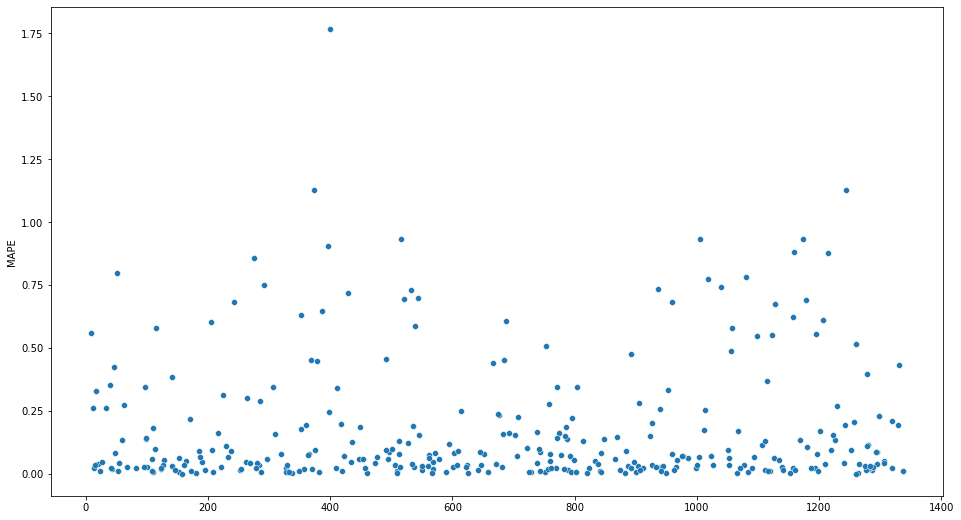

In [81]:
plt.subplots(figsize=(16,9))
sns.scatterplot(data=df41, x=df41.index,y='MAPE');

### 9.2 Total Performance

In [82]:
total_best = np.sum(df41['best_scenario'])
total_worst = np.sum(df41['worst_scenario'])
total_pred = np.sum(df41['predictions'])
total_actual = np.sum(temp['predictions'])

summary = pd.DataFrame({'Actual Scenario':total_actual, 'Total Predictions':total_pred, 'Diff':(total_actual - total_pred),
                        'Best scenario':total_best,'Worst Scenario':total_worst},index=[0])


In [83]:
pd.set_option('display.float_format', lambda x: '%.2f' % x)
summary

,Actual Scenario,Total Predictions,Diff,Best scenario,Worst Scenario
0,4479342.47,4374414.65,104927.83,5108806.56,3640022.74


### 9.3 ML Performance

In [84]:
df41['error'] = df41['charges'] - df41['predictions']
df41['error_rate'] = df41['charges'] / df41['predictions']

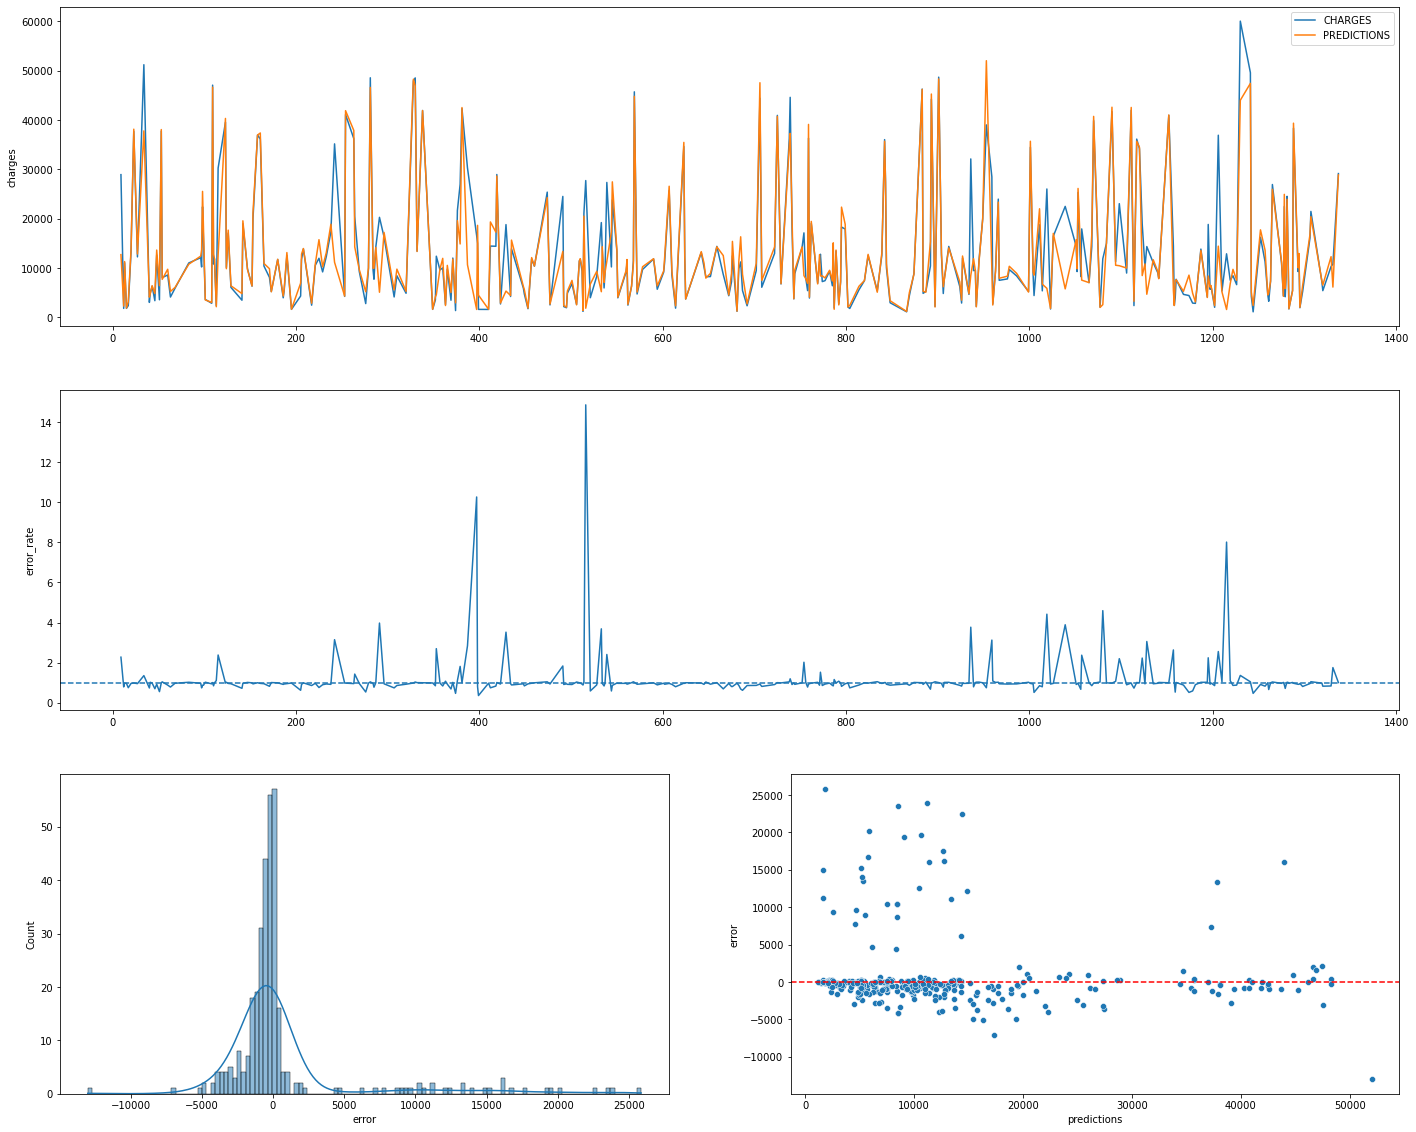

In [85]:
fig,ax = plt.subplot_mosaic("AA;BB;CD",figsize=(24,20))

sns.lineplot(x=df41.index,y='charges',data=df41, label='CHARGES', ax=ax['A'])
sns.lineplot(x=df41.index,y='predictions',data=df41,label='PREDICTIONS', ax=ax['A'])

sns.lineplot(x=df41.index,y='error_rate', data=df41, ax=ax['B'])
ax['B'].axhline(1, linestyle='--')

sns.histplot(df41['error'],kde=True,ax=ax['C'])

sns.scatterplot(x='predictions',y='error',data=df41,ax=ax['D'])
ax['D'].axhline(0, color='red', linestyle='--');

#### Observations

- Spikes on errors, on 2 crisp interactions, try to deals with it separated.